In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [25]:
book = pd.read_csv("books_data.csv")
rating = pd.read_csv("Books_rating.csv")

In [26]:
books = pd.merge(book,rating, on = 'Title')
books.shape

(3000000, 19)

In [27]:
books.isna().sum()

Title                     208
description            640225
authors                390634
image                  540306
previewLink            330623
publisher              782617
publishedDate          354581
infoLink               330623
categories             551498
ratingsCount          1360694
Id                          0
Price                 2518829
User_id                561787
profileName            561886
review/helpfulness          0
review/score                0
review/time                 0
review/summary             38
review/text                 8
dtype: int64

In [28]:
books.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Id,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN,1882931173,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,0826414346,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [29]:
books.drop_duplicates(inplace = True)
books.shape

(2991226, 19)

In [30]:
books.dropna(inplace = True)
books.shape

(174094, 19)

## EDA

#### Distribution of Books in Market based on Genre

In [31]:
books.categories.value_counts().head(10)

['Fiction']                      48109
['Religion']                     13081
['Juvenile Fiction']             11417
['Biography & Autobiography']    10138
['History']                       7374
['Business & Economics']          6130
['Family & Relationships']        5370
['Cooking']                       5196
['Computers']                     4930
['Health & Fitness']              3904
Name: categories, dtype: int64

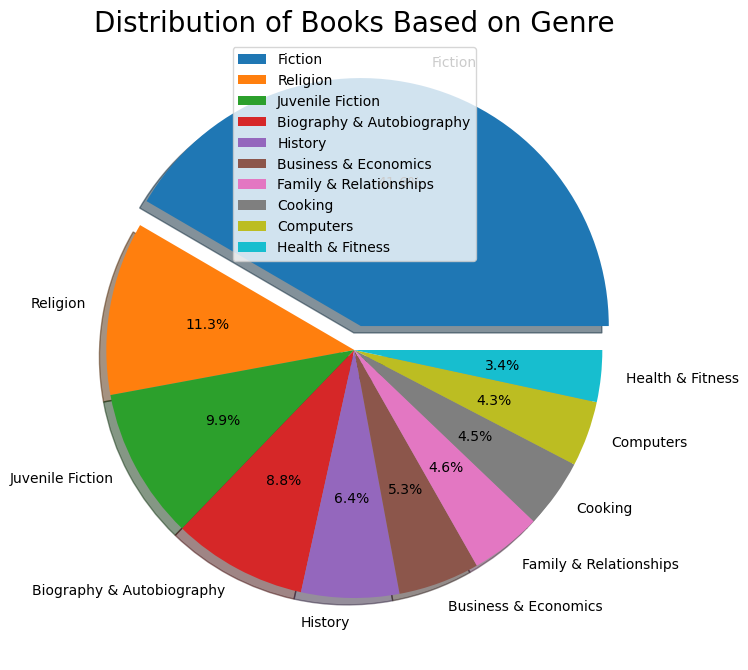

In [32]:
labels  = ["Fiction","Religion","Juvenile Fiction","Biography & Autobiography","History","Business & Economics","Family & Relationships","Cooking","Computers","Health & Fitness"]   

plt.figure(figsize=(8,10))
plt.pie(books['categories'].value_counts().head(10),explode=(0.1,0,0,0,0,0,0,0,0,0), labels=labels,autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Books Based on Genre', fontsize = 20)
plt.axis('off')
plt.legend(loc="best")
plt.show()

#### Most frequent Words in over 3 rated Reviews

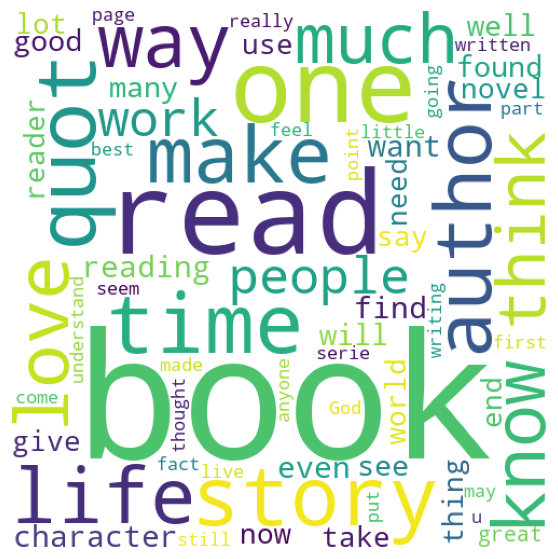

In [33]:
from wordcloud import WordCloud

wc = WordCloud(width=500,height=500,min_font_size=15,background_color='white')
spam_wc = wc.generate(books[books['review/score'] > 0]['review/text'].str.cat(sep=" "))

plt.figure(figsize=(7,7))
plt.axis('off')
plt.imshow(spam_wc)

#### Sentimental Analysis

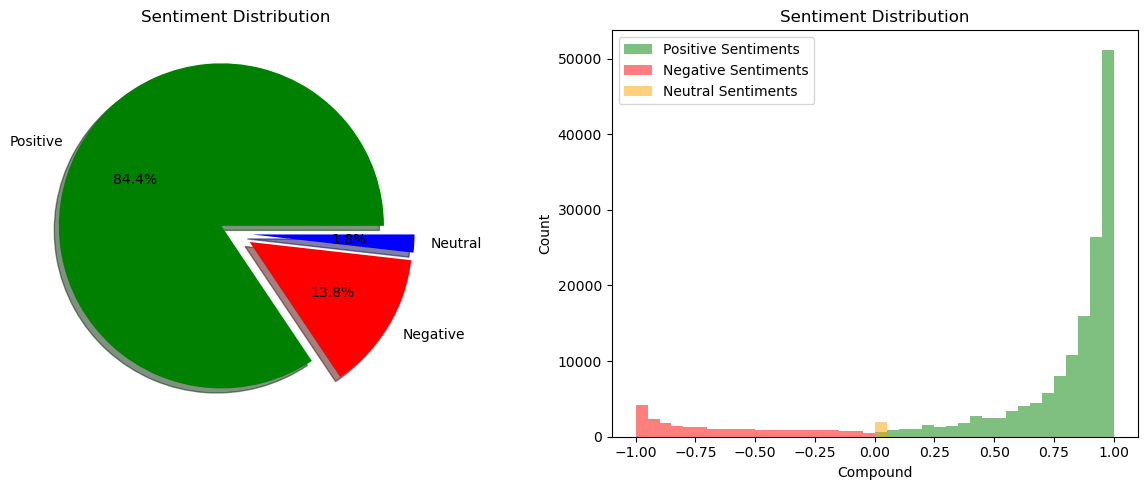

In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

books['score'] = books['review/text'].apply(lambda review: vader.polarity_scores(review))

books['compound']  = books['score'].apply(lambda score_dict: score_dict['compound'])

books['Sentiment'] = books['compound'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x < -0.05 else 'neutral')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
labels = ['Positive', 'Negative', 'Neutral']
sizes = books['Sentiment'].value_counts()
colors = ['green', 'red', 'blue']
explode = (0.1, 0.1, 0.1)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Sentiment Distribution')

plt.subplot(1, 2, 2)
positive = books[books['compound'] > 0]['compound']
negative = books[books['compound'] < 0]['compound']
neutral = books[books['compound'] == 0]['compound']

sentiments = [positive, negative, neutral]
colors = ['green', 'red', 'orange']
labels = ['Positive Sentiments', 'Negative Sentiments', 'Neutral Sentiments']

for sentiment, color, label in zip(sentiments, colors, labels):
    plt.hist(sentiment, bins=20, color=color, alpha=0.5, label=label)

plt.title('Sentiment Distribution')
plt.xlabel('Compound')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

#### Preprocessing Text

In [35]:
import string

In [17]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
def remove_punctuations(text):
    punctuations = string.punctuation
    return text.translate(str.maketrans('','',punctuations))


books['review/text'] = books['review/text'].astype(str)

In [37]:
books['review/text'] = books['review/text'].apply(lambda x: remove_punctuations(x))

In [19]:
from nltk.corpus import stopwords

In [12]:
# Lower casing the reviews
books['review/text']  = books['review/text'].str.lower()

In [38]:
STOPWORDS = set(stopwords.words("english"))

In [39]:
def remove_stopwords(text):
    return " ".join(word for word in text.split() if word not in STOPWORDS)

In [40]:
books['review/text'] = books['review/text'].apply(lambda x: remove_stopwords(x))

In [41]:
import nltk
from nltk.tokenize import word_tokenize


nltk.download('punkt')
books['review/text'] = books['review/text'].apply(lambda x: word_tokenize(x))

print(books['review/text'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roysi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


47         [With, publication, Everett, Fergusons, book, ...
48         [Everett, Ferguson, approaches, subject, early...
49         [This, book, continual, resource, It, biblical...
50         [This, useful, thorough, text, book, I, would,...
195        [This, book, history, photo, album, famous, Ge...
                                 ...                        
2999984    [This, book, Elvira, Wodruff, good, It, tells,...
2999992    [After, reading, 50, pages, restarting, every,...
2999993    [What, wrong, good, book, What, relations, mai...
2999994    [Zadie, Smiths, latest, subpar, Couplandish, t...
2999995    [Reading, first, book, The, Autograph, Man, ti...
Name: review/text, Length: 174094, dtype: object


In [42]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [18]:
lemmatizer = WordNetLemmatizer()

def pos_mapping_lemmatization(text):
    pos_tags = pos_tag(text)
    
    lemmatized_words = []
    for word, tag in pos_tags:
        if tag.startswith('N'):
            pos = 'n'
        elif tag.startswith('V'):
            pos = 'v'
        elif tag.startswith('R'):
            pos = 'r'
        else:
            pos = 'n'
        
        lemma = lemmatizer.lemmatize(word, pos)
        lemmatized_words.append(lemma)
    
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [19]:
books['review/text'] = books['review/text'].apply(lambda x: pos_mapping_lemmatization(x))

In [20]:
books.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Id,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
47,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,0802841899,25.97,ARI272XF8TOL4,Christopher J. Bray,74/81,5.0,955411200,Ecclesiological Milestone,publication everett fergusons book ecclesiolog...
48,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,0802841899,25.97,A36TPZSH8LBT1,haskell,2/3,5.0,1311465600,Early Christian development of the Church,everett ferguson approach subject early christ...
49,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,0802841899,25.97,ANX3DDV12ZRRU,GodsBreath.wordpress,2/3,4.0,1289952000,An Excellent Presentation of the Beliefs of th...,book continual resource biblical simple dr fer...
50,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,0802841899,25.97,A2H2LORTA5EZY2,Edward E. Howe,3/5,4.0,1266192000,Christ is Lord,useful thorough text book would recommend anyo...
195,The Battleship Bismarck,The Bismarck is perhaps the most famous – and ...,['Stefan Draminski'],http://books.google.com/books/content?id=nxttD...,http://books.google.nl/books?id=nxttDwAAQBAJ&p...,Bloomsbury Publishing,2018-09-20,https://play.google.com/store/books/details?id...,['History'],1.0,0887402216,34.95,A30IUAABSEHEPI,Lawrence Duckles,9/9,3.0,1055980800,The Battleship Bismarck reviewed,book history photo album famous german battles...


In [7]:
df = books[['review/text', 'review/score']]

#### Model 1 SGDClassifier using multiple feature count of TF-IDF Vectorizer

In [8]:
def multipleFeatureCount(featureCount):
    transformer = ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(max_features=featureCount), 'review/text')])
    final_data = transformer.fit_transform(df)
    
    X = final_data
    y = df['review/score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    svm = SGDClassifier()

    svm.fit(X_train, y_train)

    y_pred_train = svm.predict(X_train)
    y_pred = svm.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Feature Count: {featureCount}")
    print(f"Train accuracy: {train_accuracy:.2f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    print()

In [9]:
featureCounts = [1000,5000,10000,125000,150000,175000,200000,225000,250000,275000,300000,325000,350000,375000]
for featureCount in featureCounts:
    multipleFeatureCount(featureCount=featureCount)

Feature Count: 1000
Train accuracy: 0.63
Test accuracy: 0.64

Feature Count: 5000
Train accuracy: 0.65
Test accuracy: 0.64

Feature Count: 10000
Train accuracy: 0.65
Test accuracy: 0.64

Feature Count: 125000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 150000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 175000
Train accuracy: 0.65
Test accuracy: 0.64

Feature Count: 200000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 225000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 250000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 275000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 300000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 325000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 350000
Train accuracy: 0.66
Test accuracy: 0.64

Feature Count: 375000
Train accuracy: 0.66
Test accuracy: 0.64



#### Model 1 SGDClassifier Hyperparameter Tuning Using Maximum Feature Count

In [49]:
vectorizer = TfidfVectorizer(max_features=175000)
transformer = ColumnTransformer(transformers=[('tfidf', vectorizer, 'review/text')])
final = transformer.fit_transform(df)
X = final
y = df['review/score']

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [10 ** x for x in range(-5, 2)],
    'max_iter': [1000, 2000, 5000]
}

linear_svc = SGDClassifier()
grid_search = GridSearchCV(linear_svc, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV 1/5] END alpha=1e-05, max_iter=1000, penalty=l2;, score=0.660 total time=   4.1s
[CV 2/5] END alpha=1e-05, max_iter=1000, penalty=l2;, score=0.661 total time=   4.0s
[CV 3/5] END alpha=1e-05, max_iter=1000, penalty=l2;, score=0.659 total time=   4.1s
[CV 4/5] END alpha=1e-05, max_iter=1000, penalty=l2;, score=0.661 total time=   3.9s
[CV 5/5] END alpha=1e-05, max_iter=1000, penalty=l2;, score=0.660 total time=   3.9s
[CV 1/5] END alpha=1e-05, max_iter=1000, penalty=l1;, score=0.646 total time=   6.7s
[CV 2/5] END alpha=1e-05, max_iter=1000, penalty=l1;, score=0.647 total time=   7.1s
[CV 3/5] END alpha=1e-05, max_iter=1000, penalty=l1;, score=0.647 total time=   7.0s
[CV 4/5] END alpha=1e-05, max_iter=1000, penalty=l1;, score=0.651 total time=   6.9s
[CV 5/5] END alpha=1e-05, max_iter=1000, penalty=l1;, score=0.651 total time=   7.3s
[CV 1/5] END alpha=1e-05, max_iter=1000, penalty=elasticnet;, score=0.656 total time=   

In [12]:
print(best_params)

{'alpha': 1e-05, 'max_iter': 1000, 'penalty': 'l2'}


In [13]:
svm2 = SGDClassifier(alpha=0.00001,max_iter=1000,penalty='l2')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm2.fit(X_train, y_train)

y_pred_train = svm2.predict(X_train)
y_pred = svm2.predict(X_test)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")

Train accuracy: 0.76
Test accuracy: 0.67


#### Using Word2Vec and LSTM Model for Classification

In [56]:
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import spacy
import string

In [57]:
import gensim.downloader as api

In [58]:
wvTwitter = api.load('glove-twitter-50')

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow

In [83]:
#Using Glove Twitter Vectorizer
vocab_size = len(wvTwitter.key_to_index)
embedding_dim = wvTwitter.vector_size

X = df['review/text']
y = df['review/score']

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
max_length = 100
X_padded = pad_sequences(X_seq, maxlen=max_length)

y_ohe = pd.get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_ohe, test_size=0.2, random_state=42)

In [86]:
print(y)

0         5.0
1         5.0
2         4.0
3         4.0
4         3.0
         ... 
174089    4.0
174090    1.0
174091    4.0
174092    3.0
174093    2.0
Name: review/score, Length: 174094, dtype: float64


In [61]:
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[wvTwitter.vectors],
    input_length=max_length,
    trainable=False
)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=50, return_sequences=True, dropout=0.1))
model.add(LSTM(units=30, return_sequences=True, dropout=0.1))
model.add(LSTM(units=10, dropout=0.4))
model.add(Dense(units=5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
X_train.shape

(139275, 100)

In [63]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
4353/4353 [==============================] - 517s 117ms/step - loss: 1.1275 - accuracy: 0.6014 - val_loss: 1.0531 - val_accuracy: 0.6104
Epoch 2/10
4353/4353 [==============================] - 514s 118ms/step - loss: 1.0508 - accuracy: 0.6082 - val_loss: 0.9937 - val_accuracy: 0.6245
Epoch 3/10
4353/4353 [==============================] - 508s 117ms/step - loss: 1.0098 - accuracy: 0.6184 - val_loss: 0.9663 - val_accuracy: 0.6300
Epoch 4/10
4353/4353 [==============================] - 532s 122ms/step - loss: 0.9848 - accuracy: 0.6252 - val_loss: 0.9607 - val_accuracy: 0.6382
Epoch 5/10
4353/4353 [==============================] - 536s 123ms/step - loss: 0.9670 - accuracy: 0.6293 - val_loss: 0.9276 - val_accuracy: 0.6430
Epoch 6/10
4353/4353 [==============================] - 518s 119ms/step - loss: 0.9552 - accuracy: 0.6317 - val_loss: 0.9275 - val_accuracy: 0.6426
Epoch 7/10
4353/4353 [==============================] - 534s 123ms/step - loss: 0.9443 - accuracy: 0.6354 - val_

In [103]:
y_pred = model.predict_on_batch(X_train[0])
max_class = []
for i in y_pred:
    max_index = np.argmax(i)+1
    max_class.append(max_index)
print(max(max_class, key=max_class.count))

5


In [64]:
model.save('lstm_model.h5')

In [54]:
custom_tfidf = TfidfVectorizer()

custom_tfidf.fit(df['review/text'])

custom_tfidf.stop_words_ = None

with open("tfidf_transformer.pkl", "wb") as f:
    pickle.dump(custom_tfidf, f)

In [82]:
import pickle

f = open('sgdClassiier.pkl', 'wb')
pickle.dump(svm2, f)
f.close()

f1 = open('transformer.pkl', 'wb')
pickle.dump('vectorizer', f1)
f1.close()

f2 = open('lstmTokenizer.pkl', 'wb')
pickle.dump(tokenizer, f2, protocol=pickle.HIGHEST_PROTOCOL)
f2.close()